This notebook can be run instead of main.py for ease of use.

In [12]:
# Package Imports

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision.models import resnet18
import os.path
from tqdm import tqdm
import os
import sys
from pathlib import Path

In [13]:
# Models

class PretrainedClassifier(nn.Module):
    """Initial classifier trained on original data"""
    def __init__(self):
        super().__init__()
        # Input: 28x28
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  # 28x28 -> 28x28
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  # 28x28 -> 28x28
        self.pool = nn.MaxPool2d(2, 2)  # 28x28 -> 14x14

        # Size progression:
        # After first pool: 14x14x32
        # After conv2 + pool: 7x7x64
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # First conv + pool
        x = self.pool(F.relu(self.conv1(x)))  # 28x28 -> 14x14

        # Second conv + pool
        x = self.pool(F.relu(self.conv2(x)))  # 14x14 -> 7x7

        # Flatten and fully connected layers
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class ImageParaphraser(nn.Module):
    """ResNet-based paraphraser that maximally transforms images while preserving classification"""
    def __init__(self):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            # Input: 28x28x1
            nn.Conv2d(1, 64, kernel_size=3, padding=1),  # 28x28x64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),  # 14x14x64 - Use average pooling instead of max pooling

            # ResNet-style blocks
            self._make_res_block(64, 128),  # 14x14x128
            nn.AvgPool2d(2, 2),  # 7x7x128
            self._make_res_block(128, 256),  # 7x7x256
        )

        # Style embedding
        self.style_linear = nn.Linear(32, 256)

        # Decoder with anti-aliasing
        self.decoder = nn.Sequential(
            # 7x7x256 -> 14x14x128
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # Use bilinear upsampling
            nn.Conv2d(256, 128, kernel_size=3, padding=1),  # Anti-aliasing convolution
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # 14x14x128 -> 28x28x64
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # Smooth final output
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def _make_res_block(self, in_channels, out_channels):
        """Create a ResNet-style block with smoothing"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            # Add a small amount of average pooling to suppress high frequencies
            nn.AvgPool2d(kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        batch_size = x.size(0)

        # Generate random style vector
        style = torch.randn(batch_size, 32).to(x.device)
        style = self.style_linear(style)
        style = style.view(batch_size, -1, 1, 1)

        # Encode
        x = self.encoder(x)

        # Add style information (reduced magnitude to prevent artifacts)
        x = x + 0.05 * style.expand(-1, -1, x.size(2), x.size(3))

        # Decode with smoothing
        x = self.decoder(x)

        return x

class InterpretableClassifier(nn.Module):
    """Classifier that outputs interpretable intermediate representations"""
    def __init__(self, num_classes=10):
        super().__init__()
        self.layers = nn.ModuleList([
            # Layer 1: Edge detection and basic feature extraction
            nn.Sequential(
                nn.Conv2d(1, 32, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.Conv2d(32, 1, kernel_size=3, padding=1),
                nn.Sigmoid()
            ),
            # Layer 2: Pattern recognition
            nn.Sequential(
                nn.Conv2d(1, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.Conv2d(64, 1, kernel_size=3, padding=1),
                nn.Sigmoid()
            ),
            # Layer 3: Higher-level feature extraction
            nn.Sequential(
                nn.Conv2d(1, 128, kernel_size=3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.Conv2d(128, 1, kernel_size=3, padding=1),
                nn.Sigmoid()
            )
        ])
        
        # Final classification layer
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x, return_intermediates=False):
        intermediates = []
        current = x
        
        for layer in self.layers:
            current = layer(current)
            intermediates.append(current)
        
        logits = self.classifier(current)
        
        if return_intermediates:
            return logits, intermediates
        return logits

In [14]:
# Train initial classifier

def train_classifier(model, train_loader, test_loader, device, num_epochs=10):
    """Train the initial classifier on original data"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    model = model.to(device)  # Ensure model is on correct device
    criterion = criterion.to(device)  # Move loss function to device if needed

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader):
            # Move input data to device
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Evaluate on test set
        test_acc = evaluate_model(model, test_loader, device)
        print(f'Epoch {epoch+1}: Train Acc: {100*correct/total:.2f}%, Test Acc: {test_acc:.2f}%')


In [15]:
# Train paraphraser

def train_paraphraser(paraphraser, classifier, train_loader, device, num_epochs=2):
    """Train the paraphraser with comprehensive logging"""
    # Ensure models are on the correct device
    paraphraser = paraphraser.to(device)
    classifier = classifier.to(device)
    
    optimizer = optim.Adam(paraphraser.parameters(), lr=0.0001)
    criterion = ParaphrasingLoss(classifier)  # Assuming ParaphrasingLoss handles device internally

    # For logging
    epoch_accuracies = []
    epoch_losses = []
    confusion_matrices = []

    print("\nStarting paraphraser training:")
    print("--------------------------------")

    for epoch in range(num_epochs):
        paraphraser.train()
        running_loss = 0.0
        running_class_loss = 0.0
        running_accuracy = 0.0
        epoch_confusion = torch.zeros(10, 10)  # Initialize on CPU for accumulation
        batch_count = 0

        for images, labels in tqdm(train_loader):
            # Move data to device
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()

            # Generate paraphrased images
            paraphrased = paraphraser(images)

            # Compute losses and accuracy
            loss, class_loss, accuracy, confusion = criterion(images, paraphrased, labels)
            loss.backward()
            optimizer.step()

            # Accumulate metrics (move confusion matrix to CPU for accumulation)
            running_loss += loss.item()
            running_class_loss += class_loss.item()
            running_accuracy += accuracy
            epoch_confusion += confusion.cpu()
            batch_count += 1

            # Print progress every 100 batches
            if batch_count % 100 == 0:
                print(f"Batch {batch_count}: Loss = {loss.item():.4f}, Accuracy = {accuracy:.1f}%")

        # Compute epoch averages
        avg_loss = running_loss / batch_count
        avg_class_loss = running_class_loss / batch_count
        avg_accuracy = running_accuracy / batch_count

        # Store metrics
        epoch_accuracies.append(avg_accuracy)
        epoch_losses.append(avg_loss)
        confusion_matrices.append(epoch_confusion)

        # Print epoch summary
        print(f"\nEpoch {epoch+1}/{num_epochs}:")
        print(f"Average Loss: {avg_loss:.4f}")
        print(f"Classification Loss: {avg_class_loss:.4f}")
        print(f"Average Classification Accuracy: {avg_accuracy:.1f}%")

        # Display confusion matrix
        print("\nConfusion Matrix (True vs Predicted):")
        confusion_matrix = epoch_confusion.numpy()
        row_sums = confusion_matrix.sum(axis=1, keepdims=True)
        normalized_confusion = 100 * confusion_matrix / row_sums  # percentage scores

        # Print normalized confusion matrix
        print("\nNormalized Confusion Matrix (%):")
        print("    ", end="")
        for i in range(10):
            print(f"{i:5d}", end="")
        print("\n" + "-" * 60)

        for i in range(10):
            print(f"{i:2d} |", end="")
            for j in range(10):
                print(f"{normalized_confusion[i,j]:5.1f}", end="")  # i is true, j is predicted
            print(f" | {confusion_matrix[i].sum():.0f}")
        print("-" * 60)

        # Plot confusion matrix
        fig = plt.imshow(normalized_confusion, cmap='viridis', interpolation='nearest', origin='lower')
        plt.colorbar(fig)
        plt.title('Confusion on Paraphrased Images')
        plt.xlabel('True Class')
        plt.ylabel('Predicted Class')
        plt.show()

        # Visualize examples
        visualize_paraphrasing(paraphraser, train_loader, device, num_samples=10)

    # Plot training progress
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epoch_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epoch_accuracies)
    plt.title('Classification Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')

    plt.tight_layout()
    plt.show()

    return epoch_accuracies, epoch_losses, confusion_matrices

In [16]:
# Train interpretable classifier

def train_interpretable_classifier(model, paraphraser, train_loader, test_loader, 
                                 paraphrase_prob=1.0, num_epochs=5, device='cuda', save_dir=None):
    """
    Train the interpretable classifier. Probabilistically paraphrases input and intermediate model states.
    
    Args:
        model: The interpretable classifier model
        paraphraser: The trained paraphraser model
        train_loader: DataLoader for training data
        test_loader: DataLoader for test data
        paraphrase_prob: Probability of applying paraphrasing at each layer including input (0.0 to 1.0)
        num_epochs: Number of training epochs
        device: Device to train on
        save_dir: Directory to save models and metrics
    """
    model = model.to(device)
    paraphraser = paraphraser.to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    metrics_log = {
        'paraphrase_prob': paraphrase_prob,
        'train_acc': [],
        'train_loss': [],  # Added to track loss
        'test_acc': [],
        'batch_metrics': {  # Added to track per-batch metrics
            'loss': [],
            'acc': []
        },
        'layer_metrics': {i: {'mse': [], 'cosine_sim': [], 'was_paraphrased': []} 
                         for i in range(len(model.layers) + 1)}  # +1 for input layer
    }
    
    best_acc = 0.0
    
    print(f"\nTraining with paraphrase probability: {paraphrase_prob * 100:.1f}%")
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        correct = 0
        total = 0
        batch_count = 0
        layer_diffs = [[] for _ in range(len(model.layers) + 1)]  # +1 for input layer

        for batch_idx, (images, labels) in enumerate(tqdm(train_loader)):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            # Probabilistically paraphrase input
            was_paraphrased = np.random.random() < paraphrase_prob
            if was_paraphrased:
                with torch.no_grad():
                    current = paraphraser(images)
            else:
                current = images.clone()
            
            # Store input layer metrics
            orig_norm = (images - images.min()) / (images.max() - images.min() + 1e-8)
            para_norm = (current - current.min()) / (current.max() - current.min() + 1e-8)
            
            mse = F.mse_loss(orig_norm, para_norm).item()
            cosine_sim = F.cosine_similarity(images.view(images.size(0), -1),
                                           current.view(current.size(0), -1),
                                           dim=1).mean().item()
            
            layer_diffs[0].append({
                'mse': mse, 
                'cosine_sim': cosine_sim,
                'was_paraphrased': was_paraphrased
            })
            
            # Forward pass tracking intermediates
            intermediates = []
            paraphrased_intermediates = []
            
            # Process through each layer with probabilistic paraphrasing
            for i, layer in enumerate(model.layers, 1):  # Start from 1 since 0 is input
                # Get layer output
                current = layer(current)
                intermediates.append(current)
                
                # Store original layer output
                orig_output = current.clone()
                
                # Probabilistically apply paraphrasing
                was_paraphrased = np.random.random() < paraphrase_prob
                if was_paraphrased:
                    with torch.no_grad():
                        paraphrased = paraphraser(current)
                else:
                    paraphrased = current.clone()
                    
                paraphrased_intermediates.append(paraphrased)
                
                # Calculate metrics between original and paraphrased versions
                orig_norm = (orig_output - orig_output.min()) / (orig_output.max() - orig_output.min() + 1e-8)
                para_norm = (paraphrased - paraphrased.min()) / (paraphrased.max() - paraphrased.min() + 1e-8)
                
                mse = F.mse_loss(orig_norm, para_norm).item()
                cosine_sim = F.cosine_similarity(orig_output.view(orig_output.size(0), -1),
                                               paraphrased.view(paraphrased.size(0), -1),
                                               dim=1).mean().item()
                
                layer_diffs[i].append({
                    'mse': mse, 
                    'cosine_sim': cosine_sim,
                    'was_paraphrased': was_paraphrased
                })
                current = paraphrased
            
            # Final classification
            logits = model.classifier(current)
            
            # Calculate loss
            class_loss = criterion(logits, labels)
            reg_loss = sum(F.mse_loss(inter, para) 
                          for inter, para in zip(intermediates, paraphrased_intermediates))
            
            total_loss = class_loss + 0.1 * reg_loss
            total_loss.backward()
            optimizer.step()

            # Update metrics
            batch_loss = total_loss.item()
            epoch_loss += batch_loss
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            batch_count += 1

            # Store batch-level metrics
            metrics_log['batch_metrics']['loss'].append(batch_loss)
            metrics_log['batch_metrics']['acc'].append(100 * (predicted == labels).sum().item() / labels.size(0))

            if batch_idx % 100 == 0:  # Reduced frequency for more meaningful plots
                # Include the input paraphrasing in visualization
                all_paraphrased = [current] + paraphrased_intermediates  # current is the possibly paraphrased input
                visualize_intermediates(images, intermediates, 
                                     all_paraphrased,
                                     layer_diffs,  # Pass layer_diffs to track paraphrasing
                                     epoch, batch_idx)
                
                # Log layer statistics
                for i in range(len(model.layers) + 1):
                    layer_metrics = layer_diffs[i][-100:]  # Use last 100 batches
                    metrics_log['layer_metrics'][i]['mse'].append(
                        np.mean([m['mse'] for m in layer_metrics]))
                    metrics_log['layer_metrics'][i]['cosine_sim'].append(
                        np.mean([m['cosine_sim'] for m in layer_metrics]))
                    metrics_log['layer_metrics'][i]['was_paraphrased'].append(
                        np.mean([m['was_paraphrased'] for m in layer_metrics]))
                    
                print(f'\nLayer Statistics (Paraphrase Prob: {paraphrase_prob * 100:.1f}%):')
                for i in range(len(model.layers) + 1):
                    layer_name = "Input" if i == 0 else f"Layer {i}"
                    paraphrase_rate = np.mean([m['was_paraphrased'] for m in layer_diffs[i][-100:]])
                    print(f'{layer_name}:')
                    print(f'  MSE: {metrics_log["layer_metrics"][i]["mse"][-1]:.4f}')
                    print(f'  Cosine Similarity: {metrics_log["layer_metrics"][i]["cosine_sim"][-1]:.4f}')
                    print(f'  Actual Paraphrase Rate: {paraphrase_rate * 100:.1f}%')

        # Epoch-level metrics
        train_acc = 100 * correct / total
        train_loss = epoch_loss / batch_count
        test_acc = evaluate_model(model, test_loader, device)
        
        metrics_log['train_acc'].append(train_acc)
        metrics_log['train_loss'].append(train_loss)
        metrics_log['test_acc'].append(test_acc)
        
        print(f'\nEpoch {epoch+1} (Paraphrase Prob: {paraphrase_prob * 100:.1f}%):')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%')
        
        # Plot training progress
        plot_training_progress(metrics_log)
        
        # Save best model if specified
        if save_dir and test_acc > best_acc:
            best_acc = test_acc
            save_path = Path(save_dir) / f'interpretable_classifier_p{paraphrase_prob:.2f}.pth'
            torch.save(model.state_dict(), save_path)
    
    return metrics_log


In [17]:
# Paraphraser loss function

class ParaphrasingLoss(nn.Module):
    """Simplified loss function focused on classification preservation with moderate transformation"""
    def __init__(self, classifier, classification_weight=5.0, transform_weight=0.5):
        super().__init__()
        self.classifier = classifier
        self.classification_weight = classification_weight
        self.transform_weight = transform_weight

    def forward(self, original, paraphrased, true_labels):
        # Classification preservation using original classifier
        with torch.no_grad():
            original_logits = self.classifier(original)
        paraphrased_logits = self.classifier(paraphrased)

        classification_loss = F.cross_entropy(paraphrased_logits, true_labels)

        # Simple L2 difference to encourage moderate transformation
        transform_loss = -F.mse_loss(original, paraphrased)  # Negative because we want some difference

        # Total loss
        total_loss = (self.classification_weight * classification_loss +
                     self.transform_weight * transform_loss)

        # For logging: compute classification accuracy
        with torch.no_grad():
            _, predicted = torch.max(paraphrased_logits, 1)
            correct = (predicted == true_labels).sum().item()
            total = true_labels.size(0)
            accuracy = 100 * correct / total

            # Get confusion matrix data
            confusion = torch.zeros(10, 10, device=original.device)
            for t, p in zip(true_labels, predicted):
                confusion[t.item(), p.item()] += 1

        return total_loss, classification_loss, accuracy, confusion


In [18]:
# Visualisation and evaluation

def visualize_paraphrasing(paraphraser, train_loader, device, num_samples=10):
    """Helper function to visualize paraphrased images"""
    # Get a batch of images
    images, _ = next(iter(train_loader))
    images = images[:num_samples].to(device)
    
    # Generate paraphrased images
    with torch.no_grad():
        paraphrased = paraphraser(images)
    
    # Move tensors to CPU for visualization
    original_images = images.cpu()
    paraphrased_images = paraphrased.cpu()
    
    # Plot original vs paraphrased
    plt.figure(figsize=(20, 4))
    for i in range(num_samples):
        # Original
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(original_images[i].squeeze(), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Original')
        
        # Paraphrased
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(paraphrased_images[i].squeeze(), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Paraphrased')
    
    plt.tight_layout()
    plt.show()

def evaluate_model(model, test_loader, device):
    """Evaluate model on test set"""
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return 100 * correct / total

def visualize_intermediates(images, intermediates, paraphrased, layer_diffs, epoch, step, num_samples=4):
    """
    Visualize random sample of images, their intermediate representations, and paraphrased versions.
    Clearly indicates which versions were actually paraphrased vs copied.
    """
    batch_size = images.size(0)
    indices = torch.randperm(batch_size)[:num_samples]
    
    for idx in indices:
        num_cols = len(intermediates) + 1  # +1 for original image
        plt.figure(figsize=(3 * num_cols, 6))
        
        # Original image and its paraphrased version
        plt.subplot(2, num_cols, 1)
        plt.imshow(images[idx].cpu().squeeze(), cmap='gray')
        plt.title('Original Input')
        plt.axis('off')
        
        # Get current input (either paraphrased or copied version)
        current_input = paraphrased[0] if isinstance(paraphrased[0], torch.Tensor) else paraphrased[0][idx]
        
        # Input layer paraphrasing status
        was_paraphrased = layer_diffs[0][-1]['was_paraphrased']
        status = "Paraphrased" if was_paraphrased else "Copied"
        plt.subplot(2, num_cols, num_cols + 1)
        plt.imshow(current_input.detach().cpu().squeeze(), cmap='gray')
        plt.title(f'Input ({status})')
        plt.axis('off')
        
        # Intermediate representations and their paraphrased versions
        for i, (inter, para) in enumerate(zip(intermediates, paraphrased[1:])):
            # Original intermediate
            plt.subplot(2, num_cols, i + 2)
            plt.imshow(inter[idx].detach().cpu().squeeze(), cmap='gray')
            plt.title(f'Layer {i+1}')
            plt.axis('off')
            
            # Paraphrasing status for this layer
            was_paraphrased = layer_diffs[i+1][-1]['was_paraphrased']
            status = "Paraphrased" if was_paraphrased else "Copied"
            
            # Paraphrased version
            plt.subplot(2, num_cols, num_cols + i + 2)
            plt.imshow(para[idx].detach().cpu().squeeze(), cmap='gray')
            plt.title(f'L{i+1} ({status})')
            plt.axis('off')
        
        plt.suptitle(f'Epoch {epoch+1}, Step {step}, Sample {idx.item()}')
        plt.tight_layout()
        plt.show()

def compare_training_results(metrics_logs):
    """Compare and visualize results from different paraphrasing probabilities"""
    plt.figure(figsize=(15, 10))
    
    # Plot test accuracy comparison
    plt.subplot(2, 2, 1)
    for metrics in metrics_logs:
        prob = metrics['paraphrase_prob']
        plt.plot(metrics['test_acc'], label=f'Prob={prob:.1f}')
    plt.title('Test Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    # Plot average MSE per layer
    plt.subplot(2, 2, 2)
    for metrics in metrics_logs:
        prob = metrics['paraphrase_prob']
        layer_mses = []
        for layer in range(len(metrics['layer_metrics'])):
            avg_mse = np.mean(metrics['layer_metrics'][layer]['mse'])
            layer_mses.append(avg_mse)
        plt.plot(layer_mses, marker='o', label=f'Prob={prob:.1f}')
    plt.title('Average MSE by Layer')
    plt.xlabel('Layer')
    plt.ylabel('MSE')
    plt.legend()
    
    # Plot average cosine similarity per layer
    plt.subplot(2, 2, 3)
    for metrics in metrics_logs:
        prob = metrics['paraphrase_prob']
        layer_cos = []
        for layer in range(len(metrics['layer_metrics'])):
            avg_cos = np.mean(metrics['layer_metrics'][layer]['cosine_sim'])
            layer_cos.append(avg_cos)
        plt.plot(layer_cos, marker='o', label=f'Prob={prob:.1f}')
    plt.title('Average Cosine Similarity by Layer')
    plt.xlabel('Layer')
    plt.ylabel('Cosine Similarity')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [19]:
# Plot training progress

def plot_training_progress(metrics_log):
    """Plot detailed training metrics including per-batch information"""
    plt.figure(figsize=(15, 10))
    
    # Plot loss
    plt.subplot(2, 2, 1)
    plt.plot(metrics_log['batch_metrics']['loss'], label='Batch Loss', alpha=0.3)
    # Add smoothed version
    window = min(50, len(metrics_log['batch_metrics']['loss']))
    if window > 0:
        smoothed = np.convolve(metrics_log['batch_metrics']['loss'], 
                             np.ones(window)/window, mode='valid')
        plt.plot(smoothed, label='Smoothed Loss', linewidth=2)
    plt.title('Training Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracies
    plt.subplot(2, 2, 2)
    plt.plot(metrics_log['batch_metrics']['acc'], label='Batch Accuracy', alpha=0.3)
    # Add smoothed version
    if window > 0:
        smoothed = np.convolve(metrics_log['batch_metrics']['acc'], 
                             np.ones(window)/window, mode='valid')
        plt.plot(smoothed, label='Smoothed Accuracy', linewidth=2)
    plt.plot(np.arange(0, len(metrics_log['batch_metrics']['acc']), 
                      len(metrics_log['batch_metrics']['acc'])//len(metrics_log['test_acc'])),
             metrics_log['test_acc'], label='Test Accuracy', linewidth=2)
    plt.title('Accuracy')
    plt.xlabel('Batch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    # Plot paraphrasing rates
    plt.subplot(2, 2, 3)
    for i in range(len(metrics_log['layer_metrics'])):
        layer_name = "Input" if i == 0 else f"Layer {i}"
        rates = metrics_log['layer_metrics'][i]['was_paraphrased']
        plt.plot(rates, label=layer_name)
    plt.title('Actual Paraphrasing Rates')
    plt.xlabel('Update Step')
    plt.ylabel('Rate')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


Using device: cpu


C:\Users\plogo\AppData\Local\Temp\ipykernel_9892\2467918024.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.load_state_dict(torch.load(classifier_path, map_l

Loading pretrained classifier...
Loading pretrained paraphraser...

Training classifier with 0.0% paraphrasing probability

Training with paraphrase probability: 0.0%


  0%|          | 0/938 [00:00<?, ?it/s]

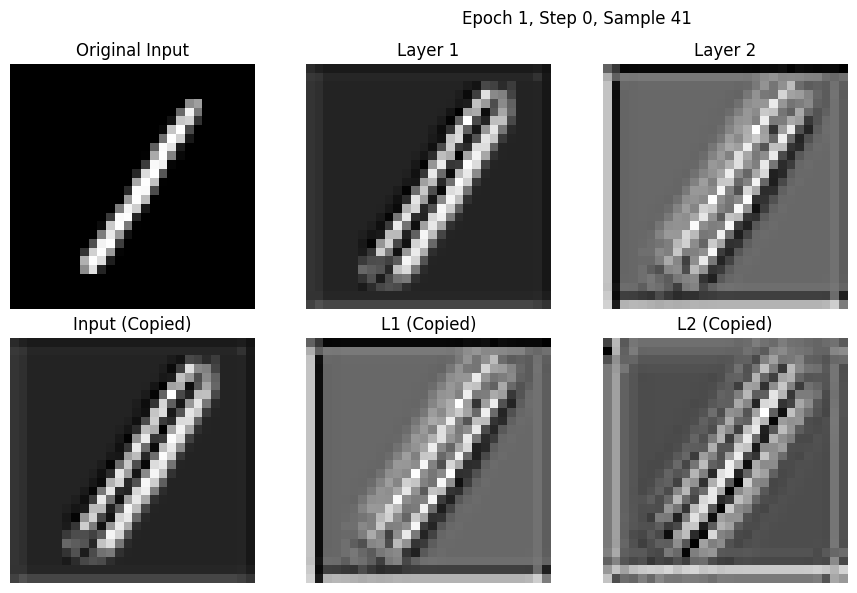

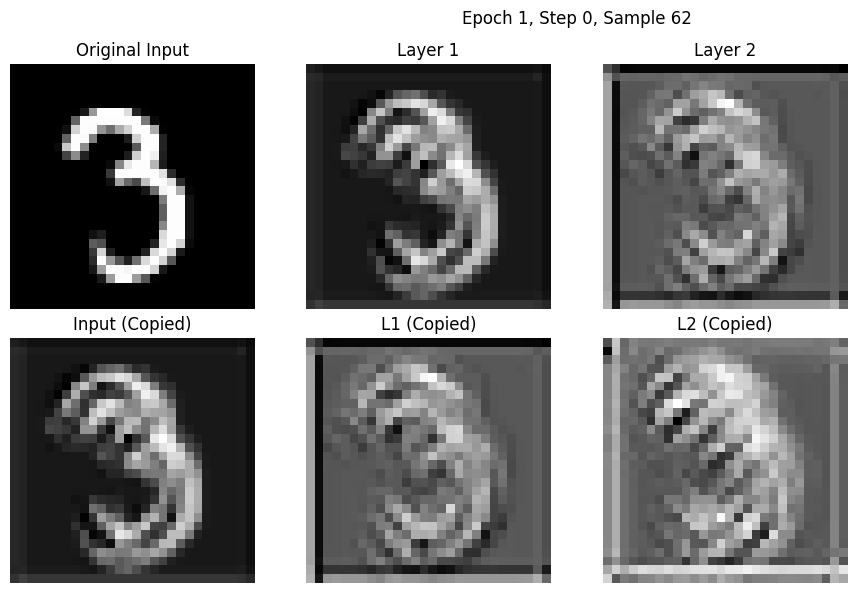

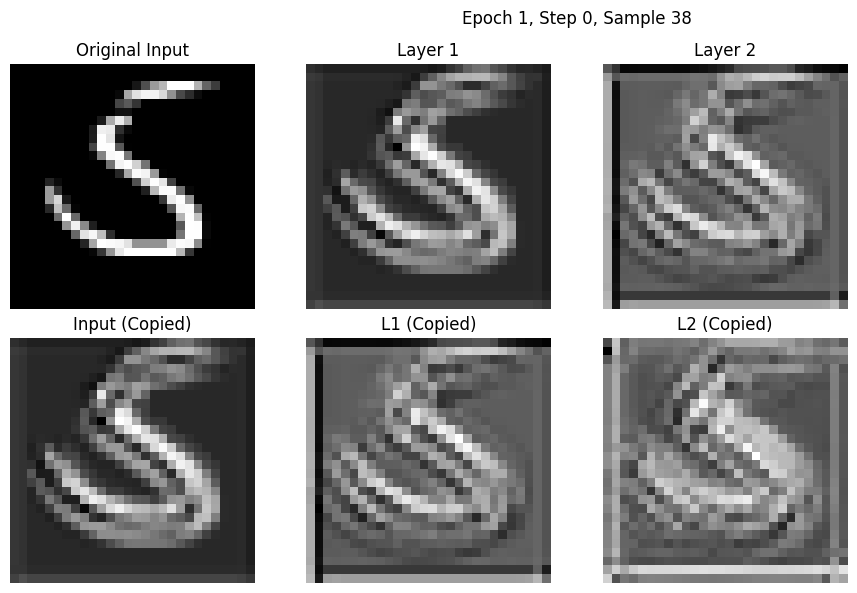

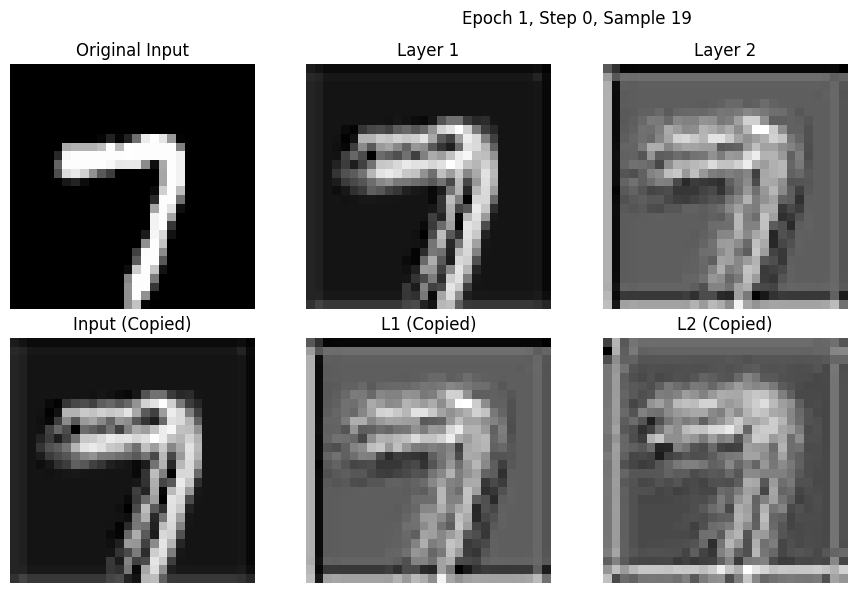

  0%|          | 1/938 [00:21<5:38:57, 21.71s/it]


Layer Statistics (Paraphrase Prob: 0.0%):
Input:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 1:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 2:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 3:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%


 11%|█         | 100/938 [01:00<04:30,  3.10it/s]

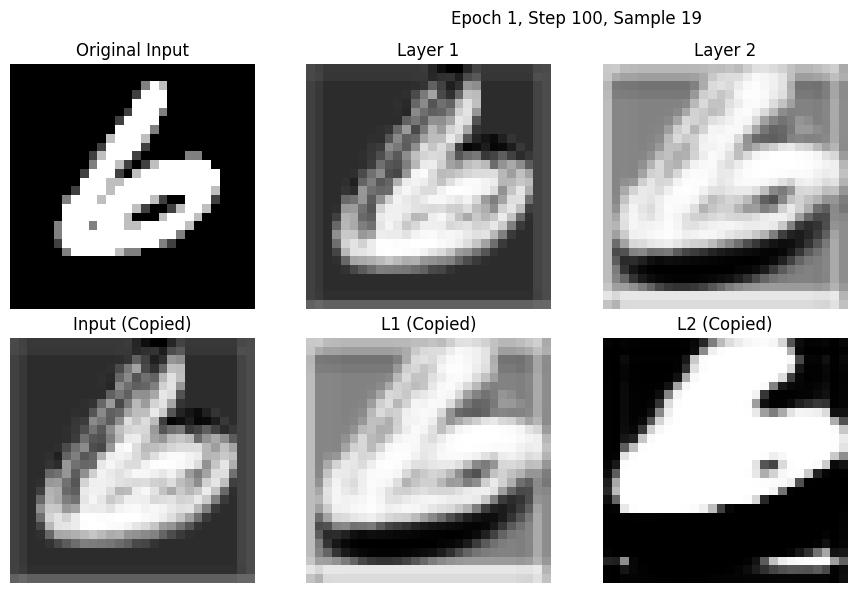

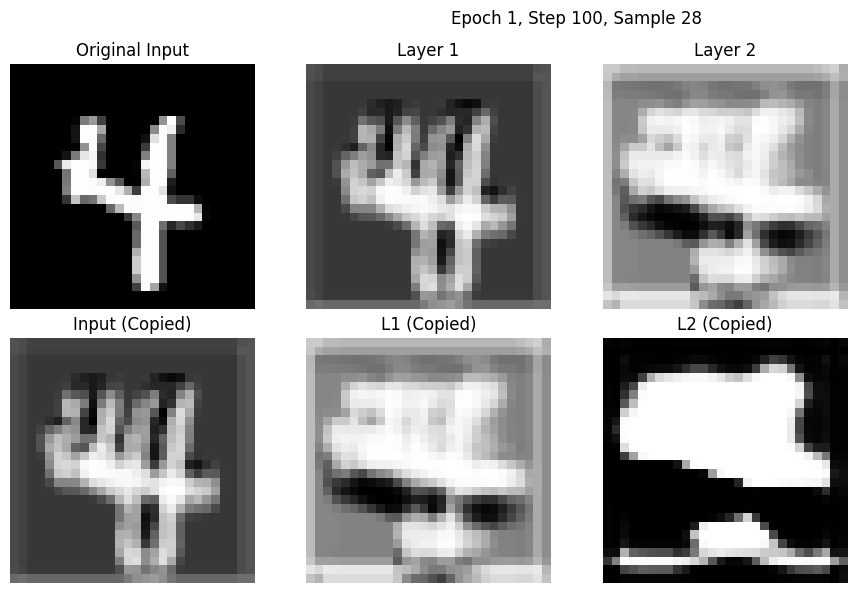

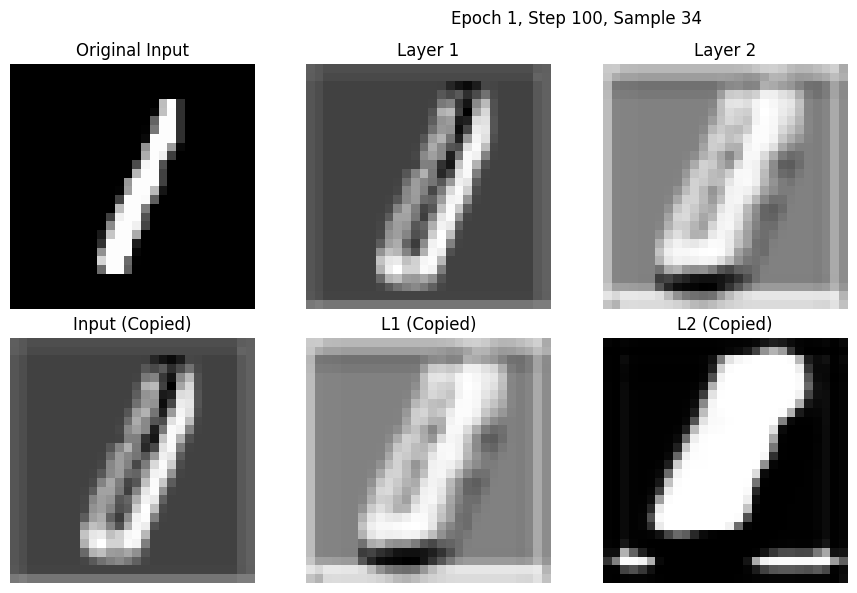

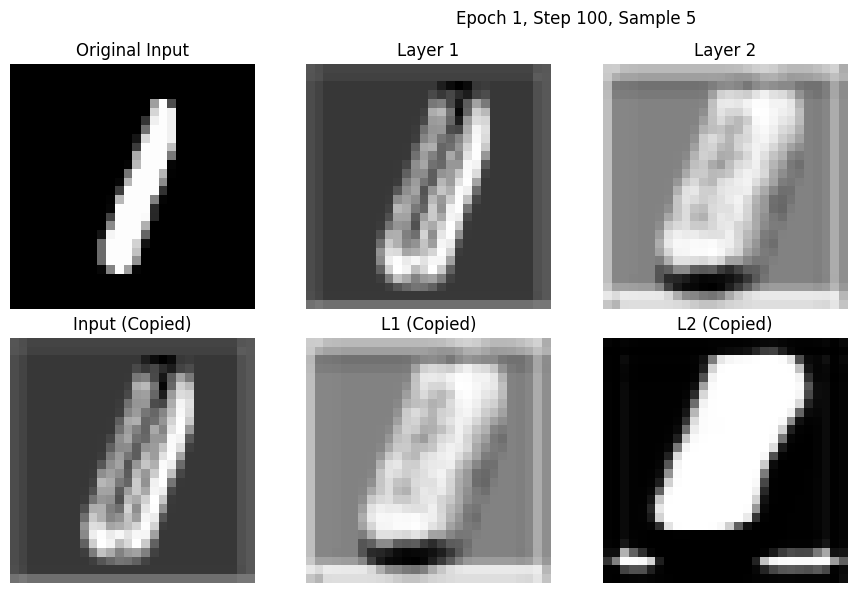

 11%|█         | 101/938 [01:03<13:25,  1.04it/s]


Layer Statistics (Paraphrase Prob: 0.0%):
Input:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 1:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 2:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 3:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%


 21%|██▏       | 200/938 [01:42<03:59,  3.09it/s]

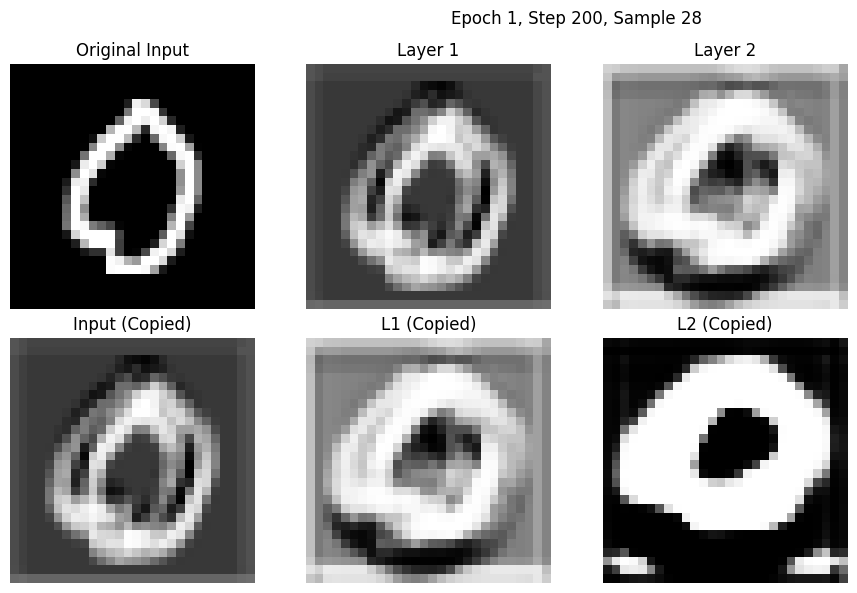

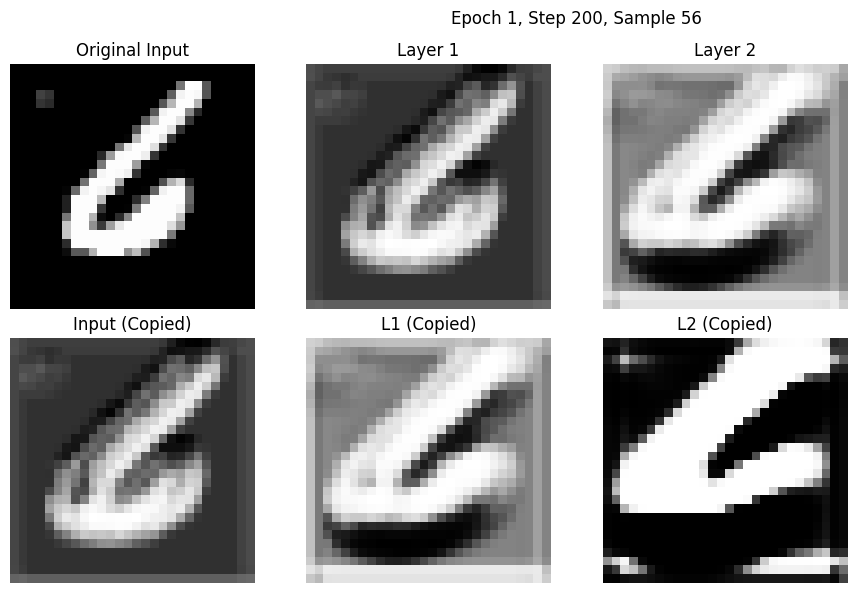

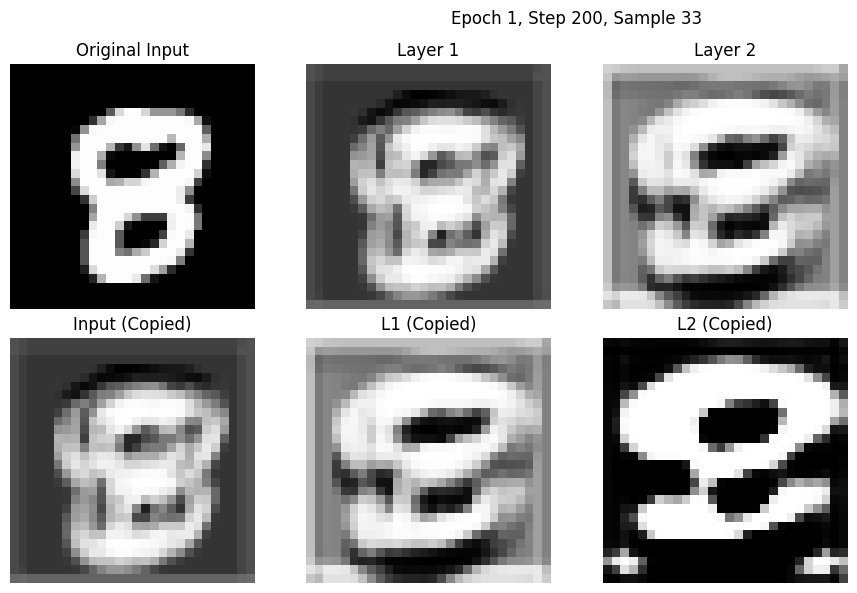

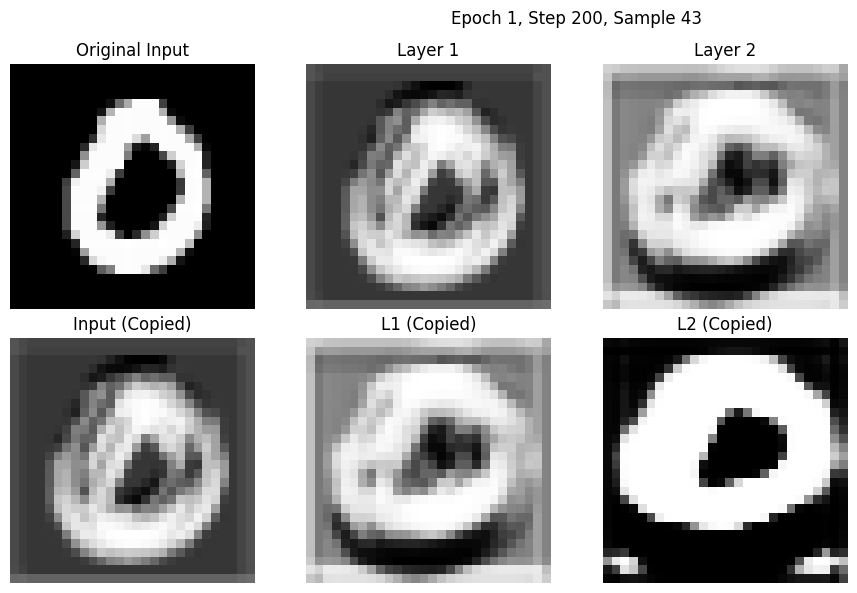

 21%|██▏       | 201/938 [01:44<10:31,  1.17it/s]


Layer Statistics (Paraphrase Prob: 0.0%):
Input:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 1:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 2:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 3:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%


 32%|███▏      | 300/938 [02:24<04:32,  2.34it/s]

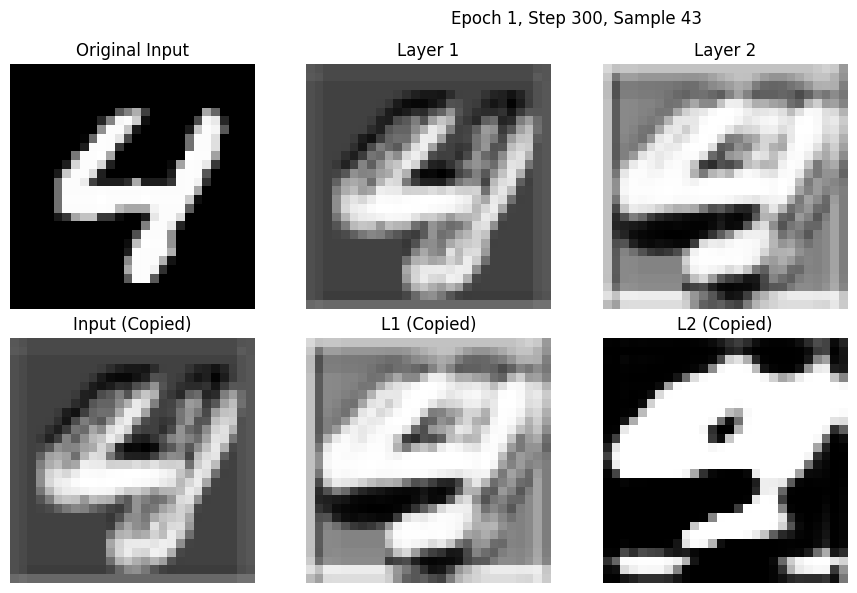

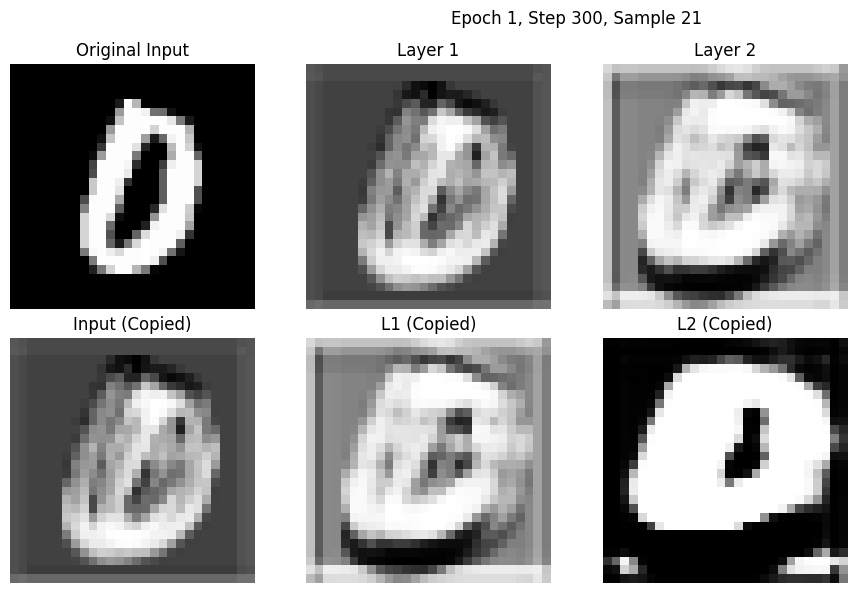

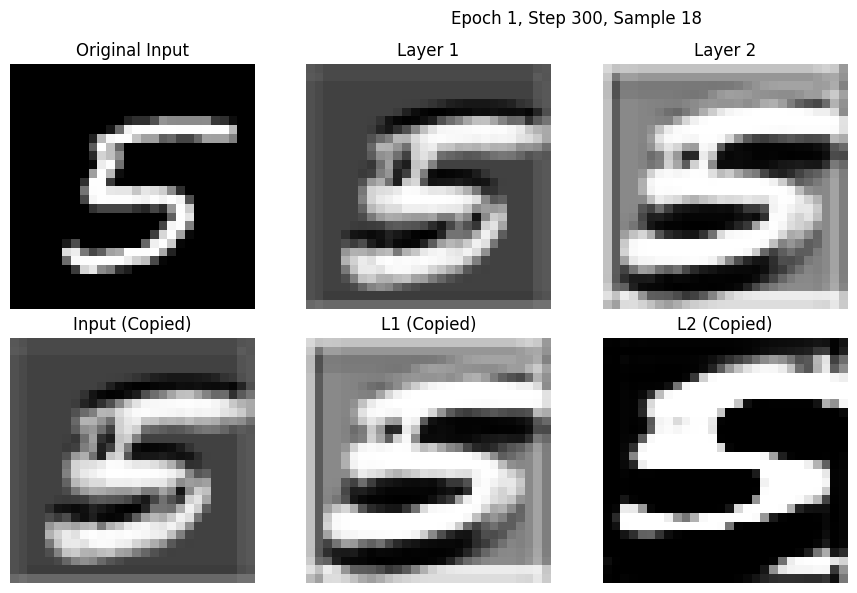

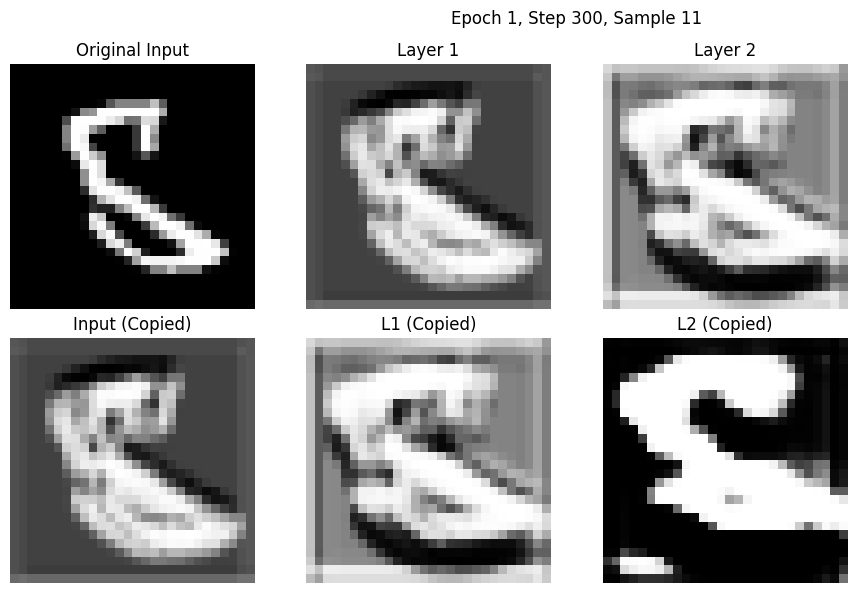

 32%|███▏      | 301/938 [02:28<14:30,  1.37s/it]


Layer Statistics (Paraphrase Prob: 0.0%):
Input:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 1:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 2:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 3:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%


 43%|████▎     | 400/938 [03:12<04:12,  2.13it/s]

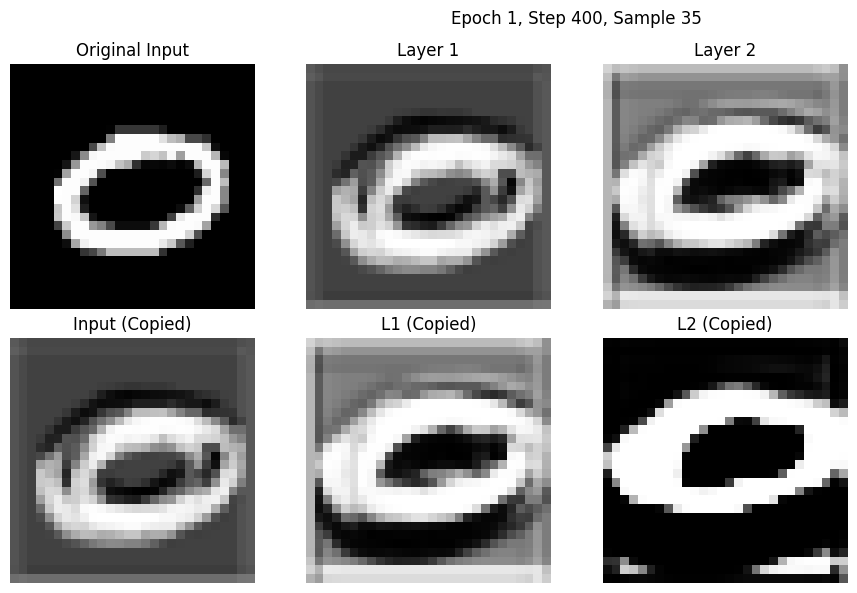

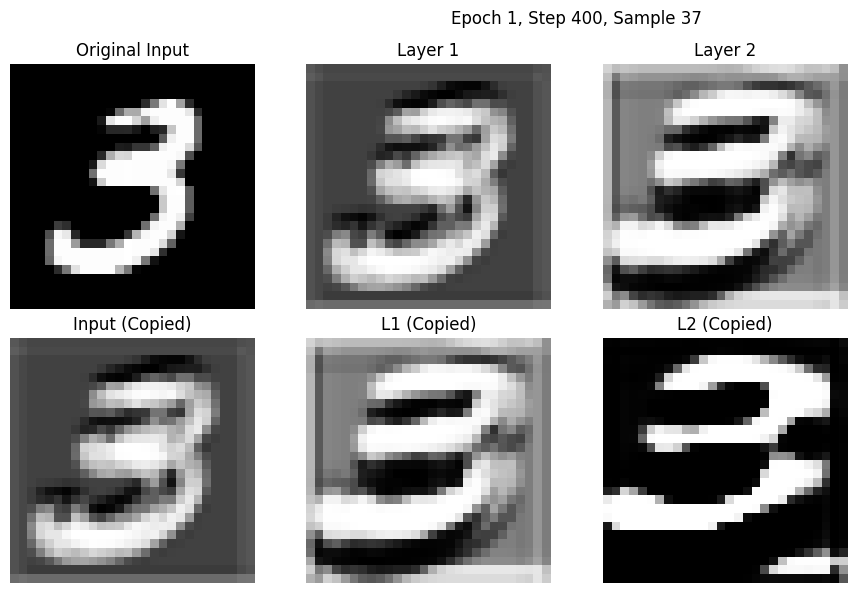

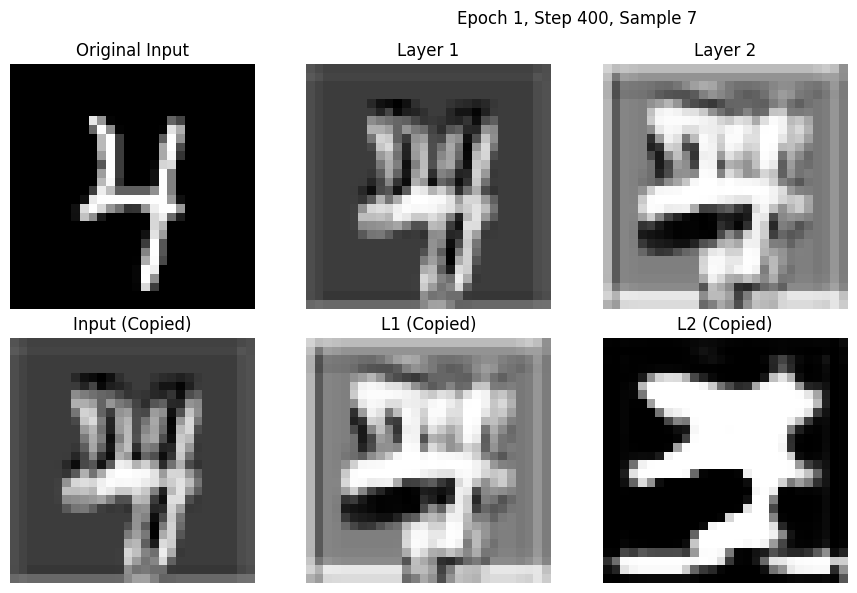

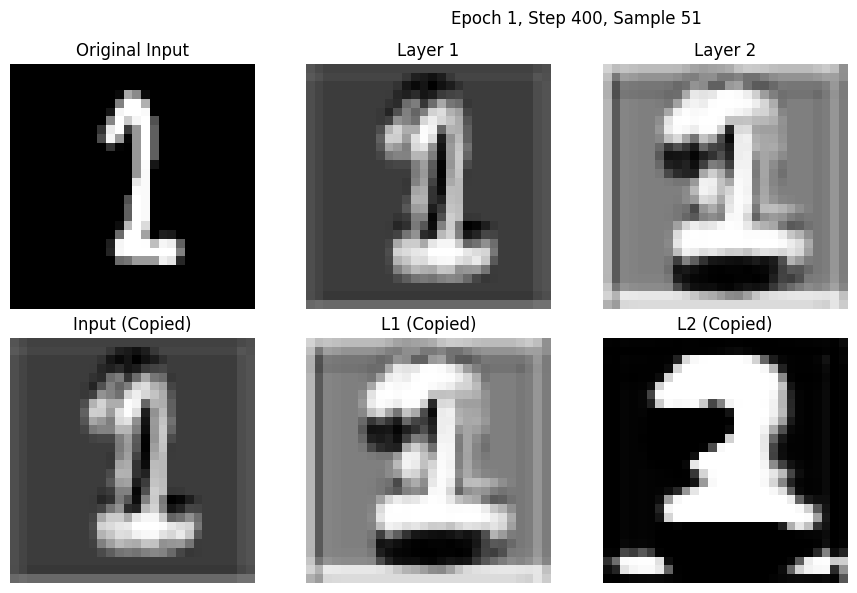

 43%|████▎     | 401/938 [03:16<12:10,  1.36s/it]


Layer Statistics (Paraphrase Prob: 0.0%):
Input:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 1:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 2:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 3:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%


 53%|█████▎    | 500/938 [04:01<02:41,  2.72it/s]

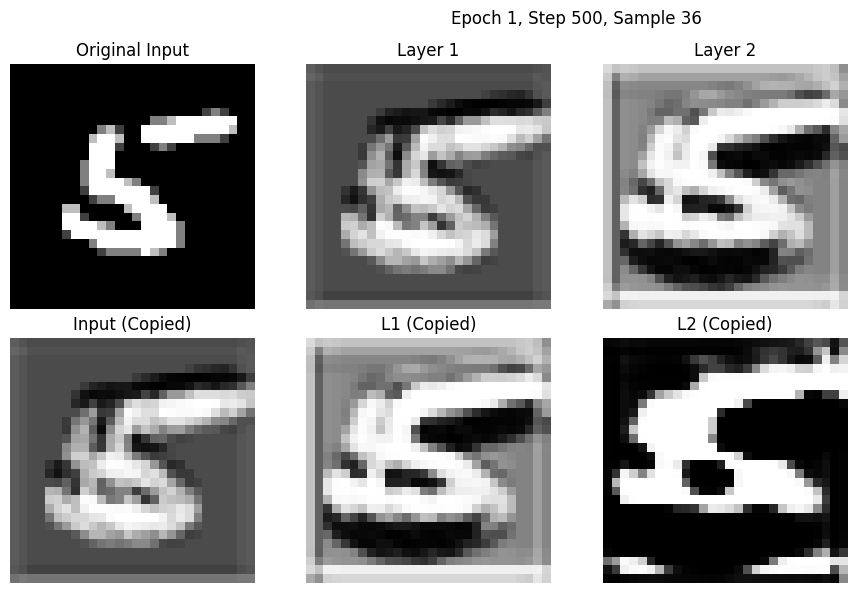

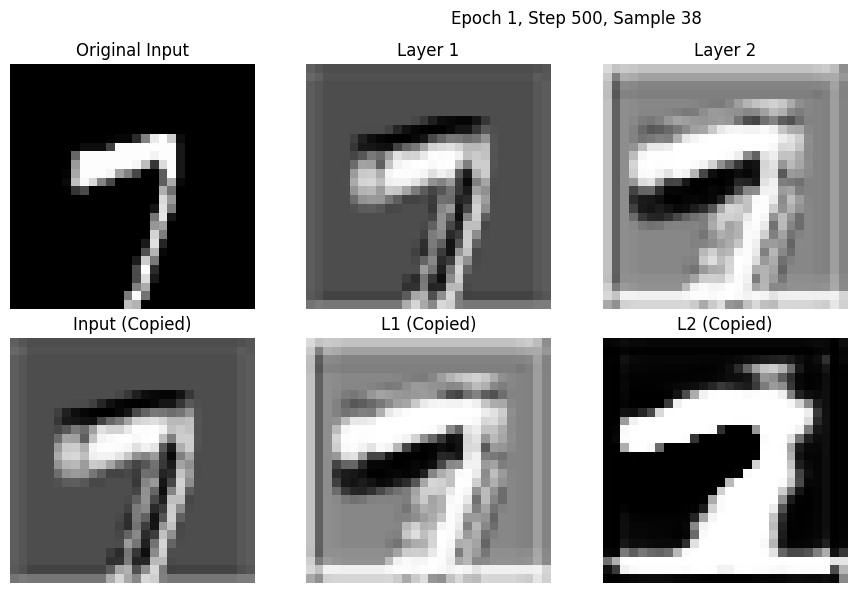

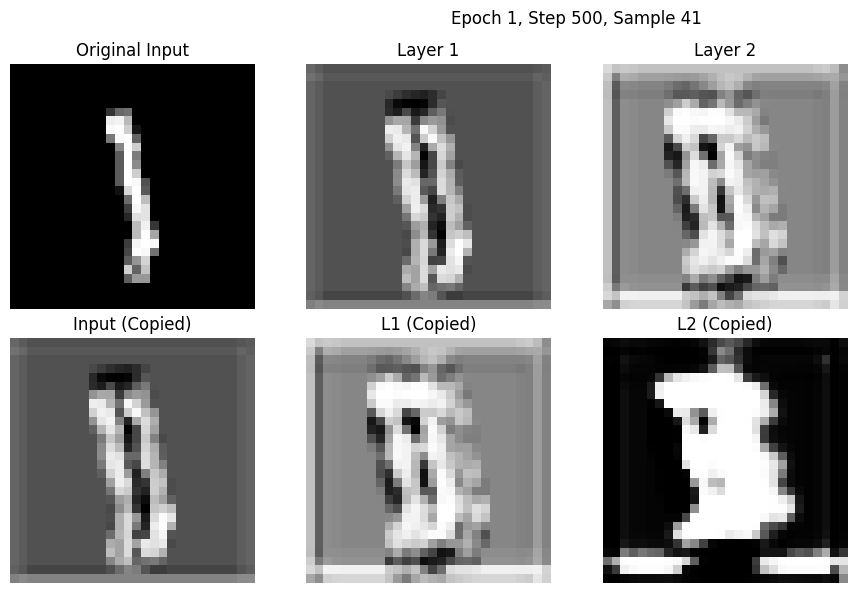

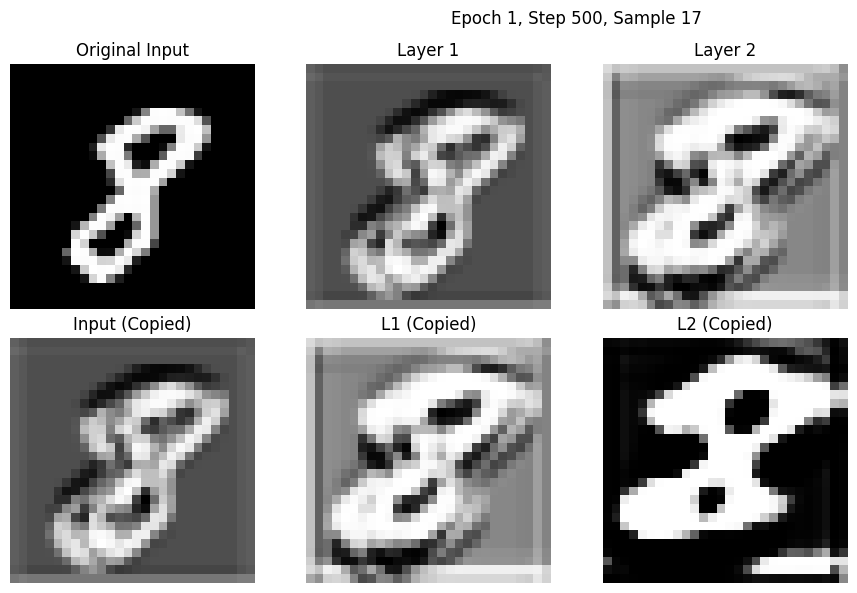

 53%|█████▎    | 501/938 [04:04<07:36,  1.05s/it]


Layer Statistics (Paraphrase Prob: 0.0%):
Input:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 1:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 2:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 3:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%


 64%|██████▍   | 600/938 [04:45<02:29,  2.25it/s]

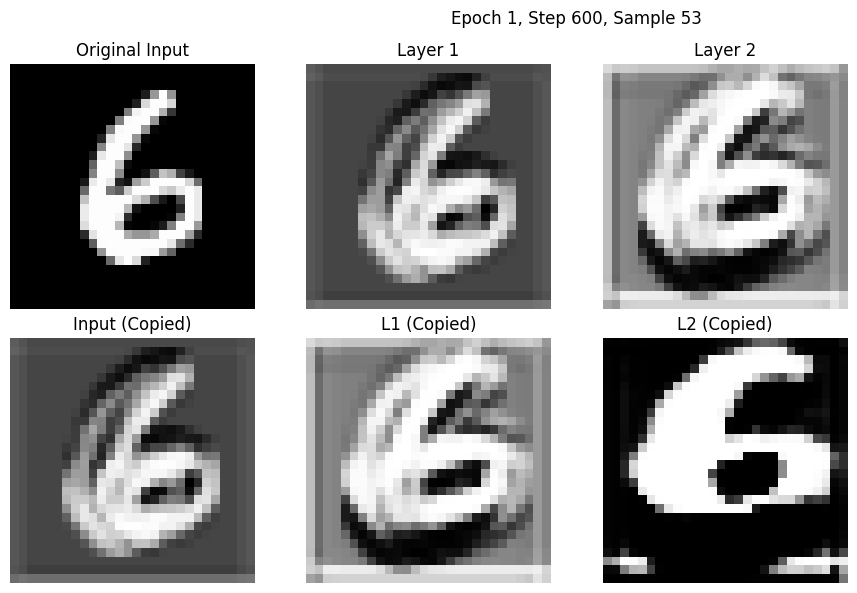

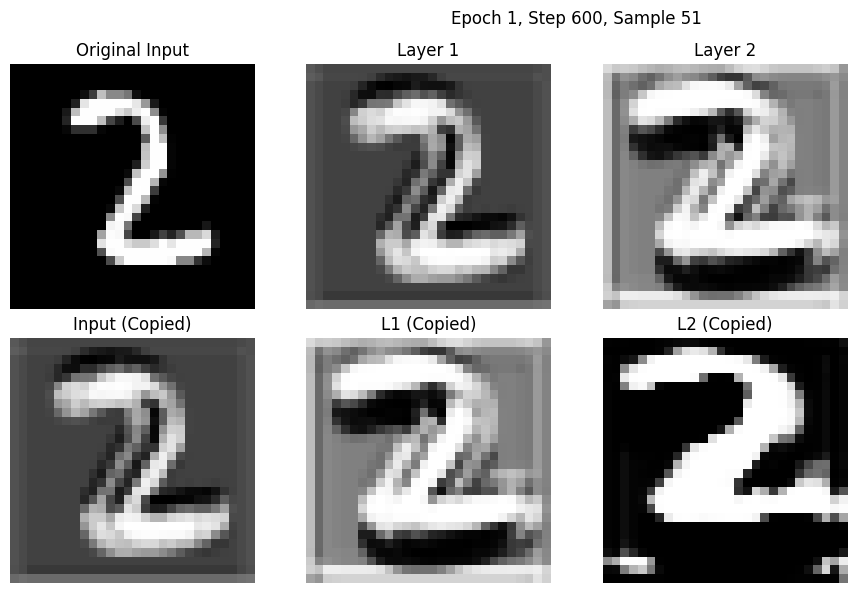

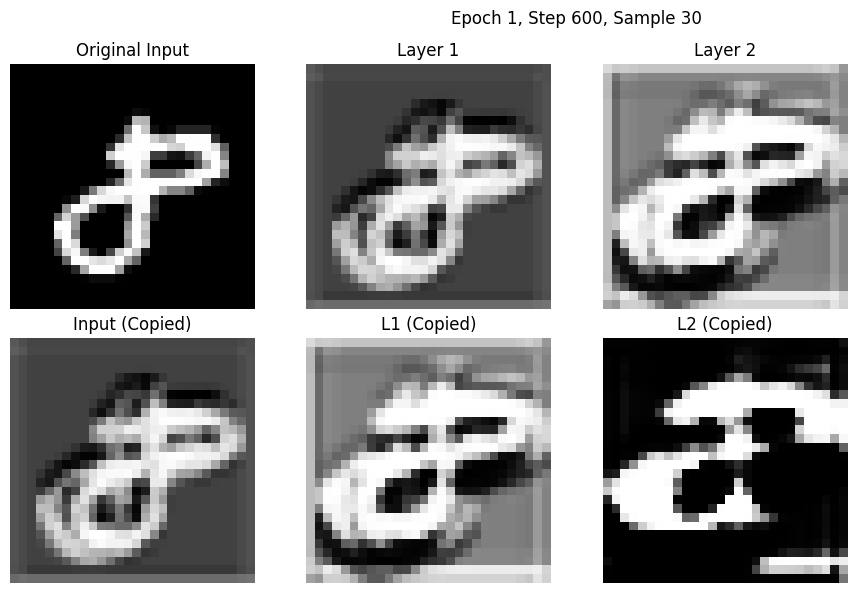

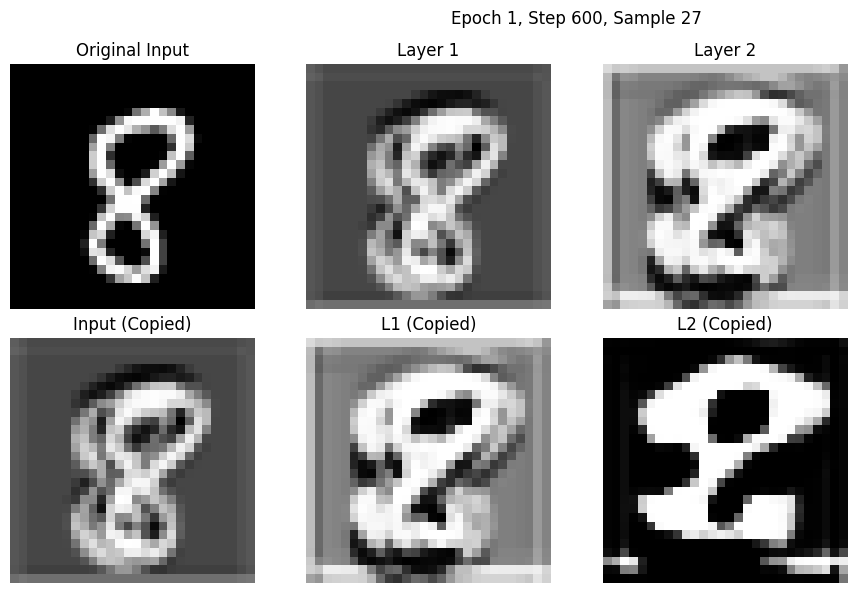

 64%|██████▍   | 601/938 [04:48<06:40,  1.19s/it]


Layer Statistics (Paraphrase Prob: 0.0%):
Input:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 1:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 2:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 3:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%


 75%|███████▍  | 700/938 [05:40<01:48,  2.19it/s]

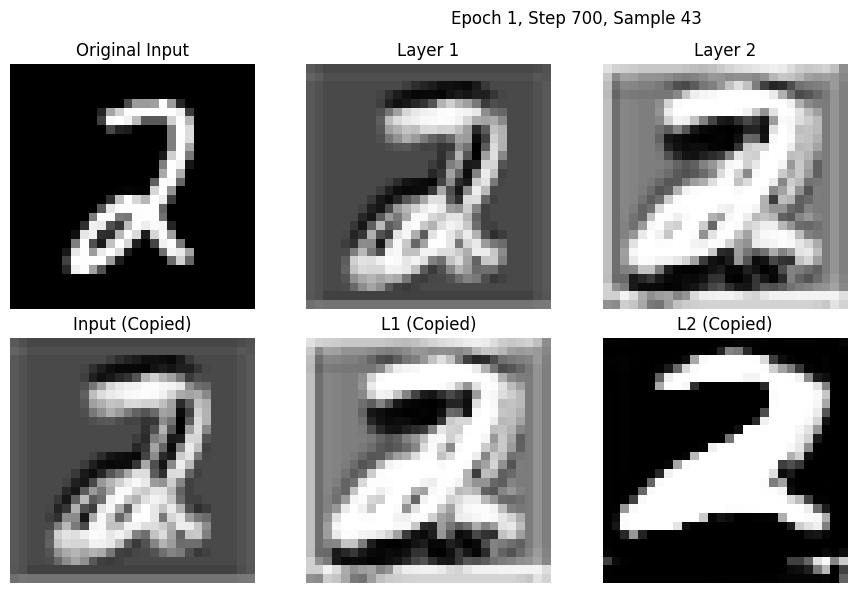

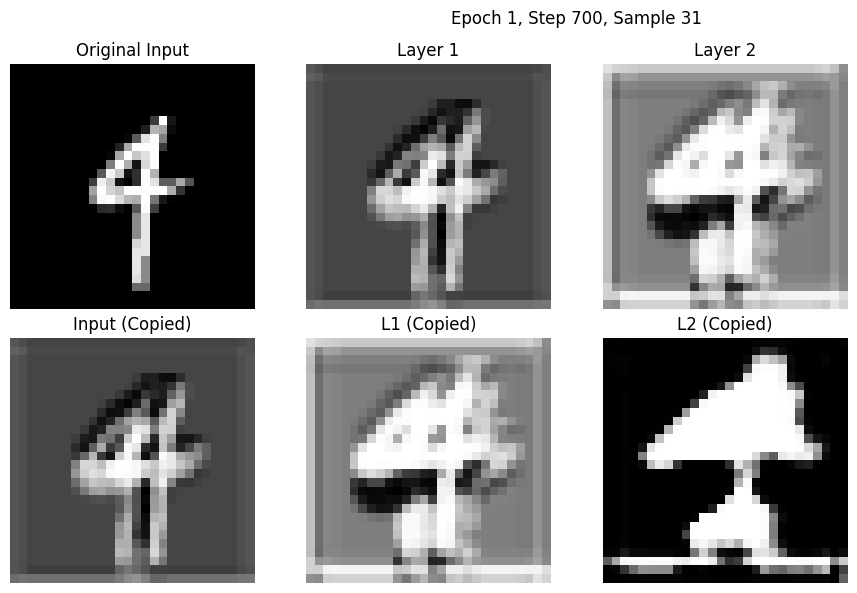

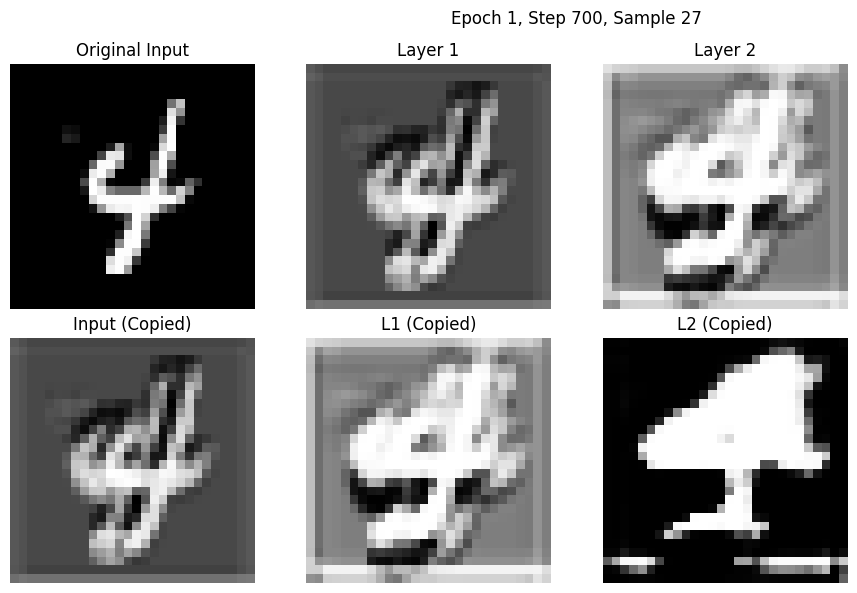

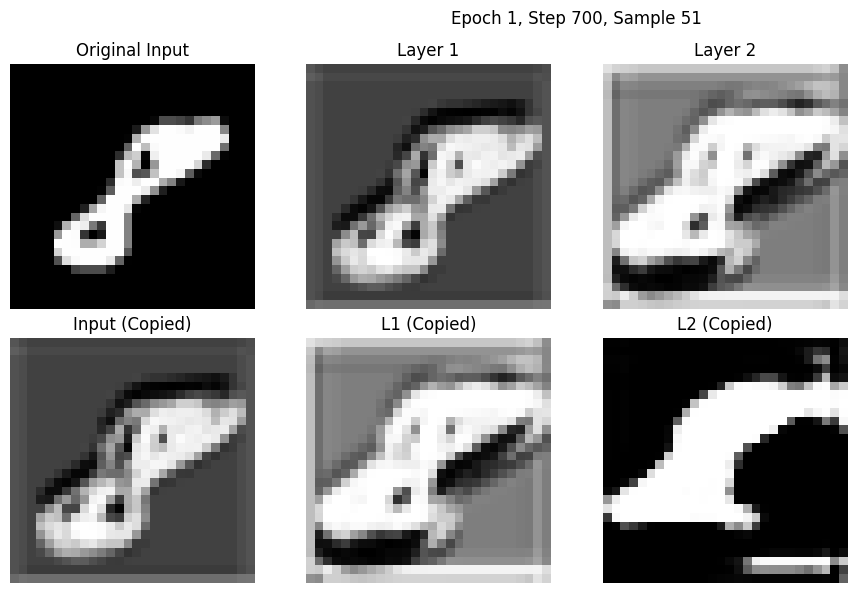

 75%|███████▍  | 701/938 [05:45<06:32,  1.66s/it]


Layer Statistics (Paraphrase Prob: 0.0%):
Input:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 1:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 2:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 3:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%


 75%|███████▌  | 705/938 [05:53<01:56,  1.99it/s]


KeyboardInterrupt: 

In [20]:
# main

def main():
    # Setup device and paths
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')
    
    root_dir = Path(os.path.abspath(''))
    data_dir = root_dir / 'data'
    models_dir = root_dir / 'models'
    models_dir.mkdir(exist_ok=True)
    
    # Setup data loaders
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    train_dataset = torchvision.datasets.MNIST(root=str(data_dir), train=True,
                                             download=True, transform=transform)
    test_dataset = torchvision.datasets.MNIST(root=str(data_dir), train=False,
                                            download=True, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, 
                            pin_memory=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, 
                            pin_memory=True, num_workers=4)
    
    # Load or train prerequisite models
    classifier = PretrainedClassifier()
    paraphraser = ImageParaphraser()
    
    # Load/train classifier
    classifier_path = models_dir / 'initial_classifier.pth'
    if classifier_path.exists():
        print("Loading pretrained classifier...")
        classifier.load_state_dict(torch.load(classifier_path, map_location=device))
    else:
        print("Training initial classifier...")
        classifier.to(device)
        train_classifier(classifier, train_loader, test_loader, device)
        torch.save(classifier.state_dict(), classifier_path)
    
    classifier.to(device)
    classifier.eval()
    
    # Load/train paraphraser
    paraphraser_path = models_dir / 'paraphraser.pth'
    if paraphraser_path.exists():
        print("Loading pretrained paraphraser...")
        paraphraser.load_state_dict(torch.load(paraphraser_path, map_location=device))
    else:
        print("Training paraphraser...")
        paraphraser.to(device)
        train_paraphraser(paraphraser, classifier, train_loader, device)
        torch.save(paraphraser.state_dict(), paraphraser_path)
    
    paraphraser.to(device)
    paraphraser.eval()
    
    # Train interpretable classifiers with different paraphrasing probabilities
    paraphrase_probs = [0.0, 0.5, 1.0]  # 0%, 50%, 100%
    all_metrics = []
    
    for prob in paraphrase_probs:
        print(f"\nTraining classifier with {prob * 100:.1f}% paraphrasing probability")
        model = InterpretableClassifier()
        metrics = train_interpretable_classifier(
            model, 
            paraphraser,
            train_loader, 
            test_loader, 
            paraphrase_prob=prob,
            device=device,
            save_dir=str(models_dir)
        )
        all_metrics.append(metrics)
        
        # Save final model and metrics. Saves separate models for each paraphrasing probability given
        torch.save(model.state_dict(), 
                  models_dir / f'interpretable_classifier_p{prob:.2f}.pth')
        torch.save(metrics, 
                  models_dir / f'training_metrics_p{prob:.2f}.pth')
    
    # Compare results
    compare_training_results(all_metrics)
    
    print("\nTraining complete! Models and metrics saved in:", models_dir)

if __name__ == "__main__":
    main()